In [22]:
import cupy as np
from numpy import linalg as LA
from matplotlib import pyplot as plt
plt.set_cmap("gray") # Otherwise grayscale images look purple
%matplotlib inline

from IPython.display import display as d

In [23]:
trainxs = np.load("../comp0090_assignment_1_data/fashion-train-imgs.npz").transpose((2, 1, 0))
trainys = np.load("../comp0090_assignment_1_data/fashion-train-labels.npz")
devxs   = np.load("../comp0090_assignment_1_data/fashion-dev-imgs.npz").transpose((2, 1, 0))
devys   = np.load("../comp0090_assignment_1_data/fashion-dev-labels.npz")

In [24]:
print(trainxs.shape)
print(trainys.shape)
print(devxs.shape)
print(devys.shape)

(12000, 28, 28)
(12000,)
(1000, 28, 28)
(1000,)


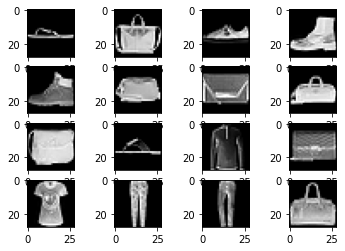

In [25]:
f, axarr = plt.subplots(4,4)
for i in range(4):
    for j in range(4):
        axarr[i, j].imshow(trainxs[np.random.randint(0, len(trainxs))].get())

## 3.3 Implementing the algorithm

In [26]:
# sigmoid for a single sample, preventing overflow
def sigmoid(z):
#     return 1. / (1. + np.exp(-z))
    return np.exp(np.fmin(z, 0)) / (1 + np.exp(-np.abs(z)))

In [27]:
# sigmoid derivative
def sigmoid_d(x):
    return sigmoid(x) * (1 - sigmoid(x))

In [28]:
# forward pass
def forward(params, x):
    x = x.reshape(28**2, 1)
    
    forward_res = {}
    forward_res["z1"] = params["W1"] @ x + params["b1"]
    forward_res["a1"] = sigmoid(forward_res["z1"])
    forward_res["z2"] = params["w2"] @ forward_res["a1"] + params["b2"]
    forward_res["a2"] = sigmoid(forward_res["z2"])
    
    return forward_res

In [29]:
# idk what those are and at this point i'm too scared to ask
def loss(y_pred, y):
    if y_pred == 0 or y_pred == 1:
        return np.array([[0]])
    return (-y * np.log(y_pred)) - ((1 - y) * np.log(1 - y_pred))

def loss_prime(y_pred, y):
    return (-y/y_pred) + (1-y)/(1-y_pred)

In [30]:
# backpropagation
def backprop(x, y, params, forward_res):
    x = x.reshape(28**2, 1)
    
    grads = {}
    
    z1 = params["W1"].dot(x) + params["b1"]
    a1 = sigmoid(z1)
    
    z2 = params["w2"].dot(a1) + params["b2"]
    y_pred = a2 = sigmoid(z2)
    
    dL_dz2 = (a2 - y) # loss_prime(y_pred, y) * sigmoid_d(z2)
    dL_dz1 = dL_dz2 * params["w2"].T * sigmoid_d(z1) #  np.multiply(dL_dz2.T.dot(params["w2"]).T, sigmoid_d(z1))
#     print(dL_dz2.shape, z2.shape)
#     print(dL_dz1.shape, z1.shape)
    grads["dw2"] = dL_dz2 * a1.T #.dot(a1.T)
    grads["db2"] = dL_dz2
    
    grads["dW1"] = dL_dz1 @ x.T #.dot(x.T)
    grads["db1"] = dL_dz1
#     print(grads["dw2"].shape, params["w2"].shape)
#     for p in grads:
#         print(grads[p].shape, params[p].shape)

    return grads

In [31]:
h = 19
img_size = 784
out_size = 1
params = {"W1": np.random.randn(h, img_size) * np.sqrt(1 / img_size),
              "b1": np.zeros((h, 1)),
              "w2": np.random.randn(out_size, h) * np.sqrt(1 / h),
              "b2": np.zeros((out_size, 1))}
backprop(trainxs[7], trainys[7], params, 0)

{'dw2': array([[-0.37487216, -0.33538275, -0.31109065, -0.28642946, -0.35481945,
         -0.24267074, -0.50045131, -0.34957706, -0.48805974, -0.24388065,
         -0.45419194, -0.37625564, -0.23586456, -0.37014416, -0.45865743,
         -0.46401504, -0.24116719, -0.22589099, -0.34581568]]),
 'db2': array([[-0.7201431]]),
 'dW1': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [-0., -0., -0., ..., -0., -0., -0.],
        [-0., -0., -0., ..., -0., -0., -0.]]),
 'db1': array([[ 0.01544809],
        [ 0.02987406],
        [ 0.02270216],
        [-0.03075202],
        [ 0.01235418],
        [ 0.07365078],
        [ 0.02225878],
        [ 0.02335994],
        [ 0.01201267],
        [ 0.00160024],
        [ 0.03705035],
        [ 0.00483976],
        [ 0.04945434],
        [ 0.01124408],
        [ 0.01454323],
        [ 0.04505046],
        [

In [32]:
def predict_mlp(x, params):    
    forward_res = forward(params, x)
    if forward_res["a2"] >= 0.5:
        return 1
    return 0

In [33]:
def predict_raw(x, params):
    forward_res = forward(params, x)
    
    return forward_res["a2"][0, 0]

In [34]:
# function to calculate accuracy
def accuracy(devxs, devys, params):
    accuracy = 0
    for i in range (devxs.shape[0]):
        yp = predict_mlp(devxs[i], params)
        if (yp == devys[i]):
            accuracy += 1
    return (accuracy / devys.shape[0]) * 100

In [35]:
# CORRECT function to determine loss
def validation_loss_c(devxs, devys, params):
    l = 0
    for i in range (devxs.shape[0]):
        yprime = predict_raw(devxs[i], params)
        if (yprime == 0 and devys[i] == 1):
            yprime += 1e-15
        elif yprime == 1 and devys[i] == 0:
            yprime -= 1e-15
        if devys[i] == 1:
            l += np.log(yprime)
        else:
            l += np.log(1 - yprime)
    return ((-1) / devys.shape[0]) * l

In [36]:
def flatten(m):
    toflatten = (m["W1"], m["b1"], m["w2"], m["b2"])
#     print([s.shape for s in toflatten])
    vec = np.zeros(sum([x.size for x in toflatten]))
    offset = 0
    for param in toflatten:
        vec[offset:offset + param.size] = param.reshape(param.size)
        offset += param.size
    return vec

def unflatten(m, vec):
    params = (m["W1"], m["b1"], m["w2"], m["b2"])
    offset = 0
    for param in params:
        param[:] = vec[offset:offset + param.size].reshape(param.shape)
        offset += param.size
    return m
fdfprime = lambda m, x, y: fdfprimeg(zero(m), m, x, y)
def fdfprimeg(gradm, m, x, y):
    epsilon = 1e-6
    vecm = flatten(m)
    vecgradm = flatten(gradm)
    for i in range(vecm.size):
        wi = vecm[i]
        vecm[i] += epsilon
        u = loss(unflatten(zero(m), vecm), x, y)
        vecm[i] = wi
        vecm[i] -= epsilon
        l = loss(unflatten(zero(m), vecm), x, y)
        vecgradm[i] = (u - l) / (2 * epsilon)
        
        vecm[i] = wi
    return unflatten(gradm, vecgradm)

In [37]:
def update_params(grads, params, lr, momentum, dW1, db1, dw2, db2):
    # use momentum 1 so dW1 = grads["dW1"], db1 = grads["db1"]...
    dW1 = momentum * dW1 + (1 - momentum) * grads["dW1"]
    db1 = momentum * db1 + (1 - momentum) * grads["db1"]
    dw2 = momentum * dw2 + (1 - momentum) * grads["dw2"]
    db2 = momentum * db2 + (1 - momentum) * grads["db2"]

    params["W1"] -= (lr * dW1)
    params["b1"] -= lr * db1
    params["w2"] -= (lr * dw2)
    params["b2"] -= lr * db2
    return params

In [38]:
def update_grads(grads, ups, batch_size):
    grads["dw2"] += ups["dw2"] / batch_size
    grads["db2"] += ups["db2"] / batch_size
    
    grads["dW1"] += ups["dW1"] / batch_size
    grads["db1"] += ups["db1"] / batch_size
    return grads

In [40]:
# permutation = np.random.permutation(xs.shape[0])
# trainxs_shuffled = xs[permutation]
# trainys_shuffled = ys[permutation]


# batches = [[i for i in range(trainxs_shuffled.shape[0])]]
# # batches

In [47]:
from sklearn.metrics import log_loss
def mlp(xs, ys, learning_rate, momentum, devxs, devys):
    img_size = 28**2
    h = 19
    out_size = 1
    
    #     stores training set loss for part 3.5
    loss_training = []
    
    #     stores training set accuracy for part 3.6
    accuracy_training = []
    
    #     stores validation set accuracy for part 3.7
    accuracy_validation = []
    
    # initialise parameters
    params = {"W1": np.random.randn(h, img_size) * np.sqrt(1 / img_size),
              "b1": np.zeros((h, 1)),
              "w2": np.random.randn(out_size, h) * np.sqrt(1 / h),
              "b2": np.zeros((out_size, 1))}
    
    grads = {}
    
    loss_old = validation_loss_c(devxs, devys, params)
    print('loss_old', loss_old)
    
#     epoch = 0
    row_epoch = 0
    epochs = 10
    for epoch in range(epochs):
        # shuffle training set
        permutation = np.random.permutation(xs.shape[0])
        trainxs_shuffled = xs[permutation]
        trainys_shuffled = ys[permutation]
        
        
        batches = [[i for i in range(trainxs_shuffled.shape[0])]]
        
        
        for batch in batches:
            grads["dw2"] = np.zeros_like(params["w2"])
            grads["db2"] = np.zeros_like(params["b2"])

            grads["dW1"] = np.zeros_like(params["W1"])
            grads["db1"] = np.zeros_like(params["b1"])

            if epoch == 0:
                dW1 = np.zeros_like(params["W1"])
                db1 = np.zeros_like(params["b1"])

                dw2 = np.zeros_like(params["w2"])
                db2 = np.zeros_like(params["b2"])

            print("epoch", epoch)
            sgd = False
            if sgd:
                for i in batch:
                    forward_res = forward(params, trainxs_shuffled[i])
                    grads = backprop(trainxs_shuffled[i], trainys_shuffled[i], params, forward_res)
                    params = update_params(grads, params, learning_rate, momentum, dW1, db1, dw2, db2)
            else:
                for i in batch:
                    forward_res = forward(params, trainxs_shuffled[i])
                    ups = backprop(trainxs_shuffled[i], trainys_shuffled[i], params, forward_res)
                    grads = update_grads(grads, ups, trainxs_shuffled.shape[0])

                params = update_params(grads, params, learning_rate, momentum, dW1, db1, dw2, db2)
        
        loss_t = validation_loss_c(xs, ys, params)
        loss_training.append(loss_t)
        
        accuracy_t = accuracy(xs, ys, params)
        accuracy_training.append(accuracy_t)
    
        accuracy_valid = accuracy(devxs, devys, params)
        accuracy_validation.append(accuracy_valid)
        
        loss_valid = validation_loss_c(devxs, devys, params)
#         print('validation loss', loss_valid)
#         print('want', log_loss(devys.get(), [predict_raw(x, params).get() for x in devxs]))
#         print('training loss', loss_t)
#         print('training accuracy', accuracy_t)
        print("Val Acc:", accuracy_valid, "Val Loss:", loss_valid, "Train Acc:", accuracy_t, "Train Loss:", loss_t)
        if np.abs(loss_valid - loss_old) == 0:
            row_epoch += 1
            if row_epoch == 5:
                break
        else:
            row_epoch = 0
        loss_old = loss_valid
#         print(params)
    return epoch, loss_training, accuracy_training, accuracy_validation

## 3.4 Training model to convergence

Convergence is defined as no improvement in validation loss over 3 consecutive parameter updates.

In [50]:
# define hyperparameters

# full-batch gradient descent, so not using batch_size as a parameter
learning_rate = 0.4
momentum = 0

In [51]:
epoch, loss_training, accuracy_training, accuracy_validation = mlp(trainxs, trainys, learning_rate, momentum, devxs, devys)

loss_old 0.7843012198166254
epoch 0
Val Acc: 70.19999999999999 Val Loss: 0.6658543788161964 Train Acc: 68.64166666666667 Train Loss: 0.6675214364790696
epoch 1
Val Acc: 75.3 Val Loss: 0.6544233201197716 Train Acc: 74.25 Train Loss: 0.6567139984724626
epoch 2
Val Acc: 76.9 Val Loss: 0.644320474634212 Train Acc: 76.04166666666666 Train Loss: 0.6468682611064701
epoch 3
Val Acc: 78.2 Val Loss: 0.6340272600980333 Train Acc: 78.23333333333333 Train Loss: 0.6367503814760869
epoch 4
Val Acc: 80.2 Val Loss: 0.6231926971070629 Train Acc: 79.95833333333333 Train Loss: 0.6260741732402967
epoch 5
Val Acc: 82.5 Val Loss: 0.6116413341312671 Train Acc: 81.54166666666667 Train Loss: 0.6146790615804644
epoch 6
Val Acc: 83.2 Val Loss: 0.5992995228327028 Train Acc: 82.83333333333334 Train Loss: 0.6024947796457252
epoch 7
Val Acc: 84.0 Val Loss: 0.5861910518406669 Train Acc: 84.00833333333333 Train Loss: 0.5895472180198666
epoch 8
Val Acc: 84.7 Val Loss: 0.5724318900912082 Train Acc: 84.975 Train Loss: 0.5

In [ ]:
# from sklearn.metrics import log_loss
# def mlp(xs, ys, learning_rate, momentum, devxs, devys):
#     img_size = 28**2
#     h = 19
#     out_size = 1
    
#     #     stores training set loss for part 3.5
#     loss_training = []
    
#     #     stores training set accuracy for part 3.6
#     accuracy_training = []
    
#     #     stores validation set accuracy for part 3.7
#     accuracy_validation = []
    
#     # initialise parameters
#     params = {"W1": np.random.randn(h, img_size) * np.sqrt(1 / img_size),
#               "b1": np.zeros((h, 1)),
#               "w2": np.random.randn(out_size, h) * np.sqrt(1 / h),
#               "b2": np.zeros((out_size, 1))}
    
#     grads = {}
    
#     loss_old = validation_loss_c(devxs, devys, params)
#     print('loss_old', loss_old)
    
#     epoch = 0
#     row_epoch = 0
        
#     while True:
#         # shuffle training set
#         permutation = np.random.permutation(xs.shape[0])
#         trainxs_shuffled = xs[permutation]
#         trainys_shuffled = ys[permutation]
        
        
#         batches = [[i for i in range(xs_shuffled.shape[0])]]
        
        
        
#         grads["dw2"] = np.zeros_like(params["w2"])
#         grads["db2"] = np.zeros_like(params["b2"])

#         grads["dW1"] = np.zeros_like(params["W1"])
#         grads["db1"] = np.zeros_like(params["b1"])
        
#         if epoch == 0:
#             dW1 = np.zeros_like(params["W1"])
#             db1 = np.zeros_like(params["b1"])
            
#             dw2 = np.zeros_like(params["w2"])
#             db2 = np.zeros_like(params["b2"])
        
#         print("epoch", epoch)
#         sgd = True
#         if sgd:
#             for i in range (trainxs.shape[0]):
#                 forward_res = forward(params, trainxs_shuffled[i])
#                 grads = backprop(trainxs_shuffled[i], trainys_shuffled[i], params, forward_res)
#                 params = update_params(grads, params, learning_rate, momentum, dW1, db1, dw2, db2)
#         else:
#             for i in range (trainxs.shape[0]):
#                 forward_res = forward(params, trainxs_shuffled[i])
#                 ups = backprop(trainxs_shuffled[i], trainys_shuffled[i], params, forward_res)
#                 grads = update_grads(grads, ups, trainxs_shuffled.shape[0])

#             params = update_params(grads, params, learning_rate, momentum, dW1, db1, dw2, db2)
        
#         loss_t = validation_loss_c(xs, ys, params)
#         loss_training.append(loss_t)
        
#         accuracy_t = accuracy(xs, ys, params)
#         accuracy_training.append(accuracy_t)
    
#         accuracy_valid = accuracy(devxs, devys, params)
#         accuracy_validation.append(accuracy_valid)
        
#         loss_valid = validation_loss_c(devxs, devys, params)
#         print('validation loss', loss_valid)
#         print('want', log_loss(devys.get(), [predict_raw(x, params).get() for x in devxs]))
#         print('training loss', loss_t)
#         print('training accuracy', accuracy_t)
#         if np.abs(loss_valid - loss_old) == 0:
#             row_epoch += 1
#             if row_epoch == 5:
#                 break
#         else:
#             row_epoch = 0
#         loss_old = loss_valid
#         epoch += 1
# #         print(params)
#     return epoch, loss_training, accuracy_training, accuracy_validation